In [1]:
print("Start")

Start


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import random
import html
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def preprocess_text(text):
    # Decode HTML (&quot; -> ", &amp; -> &; ...)
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def read_pair_files(src_file_path, trg_file_path):
    print(f"Reading and Preprocessing data from: {src_file_path} and {trg_file_path}...")

    with open(src_file_path, 'r', encoding='utf-8') as f:
        src_lines = f.read().strip().split('\n')

    with open(trg_file_path, 'r', encoding='utf-8') as f:
        trg_lines = f.read().strip().split('\n')

    assert len(src_lines) == len(trg_lines), "Error: Rows of source and target are different"

    dataset = []
    
    for src, trg in tqdm(zip(src_lines, trg_lines), total=len(src_lines)):
        src_clean = preprocess_text(src)
        trg_clean = preprocess_text(trg)
        
        if len(src_clean) > 0 and len(trg_clean) > 0:
            dataset.append({'src': src_clean, 'trg': trg_clean})

    print(f"Done! Cleaned and read: {len(dataset)} rows.")
    return dataset

In [4]:
train_src_file = "/kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.vi.txt"
train_trg_file = "/kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.en.txt"
test_src_file = "/kaggle/input/vlst-medical-mt-cleaned/clean_public_test.vi.txt"
test_trg_file = "/kaggle/input/vlst-medical-mt-cleaned/clean_public_test.en.txt"

full_train_data = read_pair_files(train_src_file, train_trg_file)
test_data = read_pair_files(test_src_file, test_trg_file)

Reading and Preprocessing data from: /kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.vi.txt and /kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.en.txt...


100%|██████████| 347379/347379 [00:07<00:00, 46698.74it/s]


Done! Cleaned and read: 347379 rows.
Reading and Preprocessing data from: /kaggle/input/vlst-medical-mt-cleaned/clean_public_test.vi.txt and /kaggle/input/vlst-medical-mt-cleaned/clean_public_test.en.txt...


100%|██████████| 3000/3000 [00:00<00:00, 45237.54it/s]

Done! Cleaned and read: 3000 rows.


In [5]:
random.shuffle(full_train_data)
split_ratio = 0.9
split_idx = int(len(full_train_data) * split_ratio)

train_data = full_train_data[:split_idx]
valid_data = full_train_data[split_idx:]

print(f"Data split: Train={len(train_data)}, Valid={len(valid_data)}, Test={len(test_data)}")

Data split: Train=312641, Valid=34738, Test=3000


In [6]:
class Vocabulary:
    def __init__(self):
        self.stoi = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.itos = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.freq_threshold = 2

    def tokenizer(self, text):
        text = text.lower().strip()
        return re.findall(r"\w+|[^\w\s]", text)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [self.stoi.get(token, self.stoi['<unk>']) for token in tokenized_text]

In [7]:
print("Building vocabulary...")
src_vocab = Vocabulary()
trg_vocab = Vocabulary()

src_texts = [item['src'] for item in train_data]
trg_texts = [item['trg'] for item in train_data]

src_vocab.build_vocabulary(src_texts)
trg_vocab.build_vocabulary(trg_texts)

print(f"Vocab Size -> Vi: {len(src_vocab.stoi)}, En: {len(trg_vocab.stoi)}")

Building vocabulary...
Vocab Size -> Vi: 27286, En: 51584


In [8]:
class ManualDataset(Dataset):
    def __init__(self, data, src_vocab, trg_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        pair = self.data[index]
        src_text = pair['src']
        trg_text = pair['trg']

        # [SOS] + [Indices] + [EOS]
        src_indices = [1] + self.src_vocab.numericalize(src_text) + [2]
        trg_indices = [1] + self.trg_vocab.numericalize(trg_text) + [2]

        return torch.tensor(src_indices), torch.tensor(trg_indices)

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        src_batch, trg_batch = zip(*batch)
        # Dynamic batch padding, only pad to size of the largest in batch
        src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=self.pad_idx, batch_first=True)
        trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=self.pad_idx, batch_first=True)
        return src_batch, trg_batch

# Transformer

In [9]:
import torch
import torch.nn as nn
import math

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=5000, drop_prob=0.1):
        super().__init__()
        self.d_model = d_model

        # Input/Output Embedding
        self.tok_emb = nn.Embedding(vocab_size, d_model)

        # Positional Encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Sin PE
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0)) # no update gradient
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # x: (Batch, Seq_Len)
        token_emb = self.tok_emb(x) * math.sqrt(self.d_model)
        # 2. Add PE
        pos_emb = self.pe[:, :x.size(1), :]
        return self.dropout(token_emb + pos_emb)

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.d_model = d_model

        # Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # Linear
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # q, k, v: (Batch, Seq_Len, d_model)
        batch_size = q.size(0)

        # 1. Linear Project & Split Heads
        # d_model -> n_head x head_dim
        Q = self.w_q(q).view(batch_size, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
        K = self.w_k(k).view(batch_size, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
        V = self.w_v(v).view(batch_size, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)

        # 2. Scaled Dot-Product Attention
        # Energy: Q * K^T / sqrt(head_dim)
        energy = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # 3. Apply Mask
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)

        # 4. Softmax & Weighted Sum
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V) # (Batch, n_head, Seq_Len, head_dim)

        # 5. Concat Heads & Final Linear
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.fc_out(x)

In [11]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # Linear -> ReLU -> Linear
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()
        # Sub-layer 1: Self Attention
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model) # Add & Norm

        # Sub-layer 2: Feed Forward
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model) # Add & Norm

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # 1. Self-Attention: Multi-Head attention with all Q,K,V from src
        _src = self.self_attn(src, src, src, src_mask)

        # Add & Norm (Residual)
        src = self.norm1(src + self.dropout(_src))

        # 2. Feed Forward
        _src = self.ffn(src)

        # Add & Norm
        src = self.norm2(src + self.dropout(_src))
        return src

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()

        # Sub-layer 1: Masked Self-Attention
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model)

        # Sub-layer 2: Cross-Attention
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.norm2 = nn.LayerNorm(d_model)

        # Sub-layer 3: Feed Forward
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # 1. Masked Self-Attention
        # Q, K, V from src. Mask: future mask
        _trg = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))

        # 2. Cross-Attention (Encoder-Decoder Attention)
        # Q: target (Decoder), K,V: source (Encoder)
        _trg = self.cross_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))

        # 3. Feed Forward
        _trg = self.ffn(trg)
        trg = self.norm3(trg + self.dropout(_trg))

        return trg

In [14]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size, trg_vocab_size,
        src_pad_idx, trg_pad_idx,
        d_model=512, n_head=8, n_layer=6, d_ff=2048,
        dropout=0.1, device="cuda"
    ):
        super().__init__()
        self.device = device
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        # 1. Input Embeddings & Positional Encoding
        self.src_embedding = TransformerEmbedding(src_vocab_size, d_model, drop_prob=dropout)
        self.trg_embedding = TransformerEmbedding(trg_vocab_size, d_model, drop_prob=dropout)

        # 2. Encoder (Nx)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)
        ])

        # 3. Decoder (Nx)
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)
        ])

        # 4. Linear & Softmax
        # PyTorch CrossEntropyLoss included Softmax
        self.fc_out = nn.Linear(d_model, trg_vocab_size)

    def make_src_mask(self, src):
        # padding mask
        # Shape: (Batch, 1, 1, Src_Len)
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)

    def make_trg_mask(self, trg):
        # padding mask
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # future mask
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        return (trg_pad_mask & trg_sub_mask).to(self.device)

    def forward(self, src, trg):
        # src: (Batch, Src_Len) -> Inputs
        # trg: (Batch, Trg_Len) -> Outputs (shifted right)

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # --- Encoder Flow ---
        # 1. Input -> Embedding + Positional Encoding
        enc_src = self.src_embedding(src)

        # 2. Nx Encoder
        for layer in self.encoder_layers:
            enc_src = layer(enc_src, src_mask)

        # --- Decoder Flow ---
        # 3. Output (shifted) -> Embedding + Positional Encoding
        output = self.trg_embedding(trg)

        # 4. Nx Decoder
        for layer in self.decoder_layers:
            output = layer(output, enc_src, trg_mask, src_mask)

        # 5. Output Probabilities
        return self.fc_out(output)

# Training

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import re
from collections import Counter
import math
import time

In [16]:
# --- Hyperparameters ---
BATCH_SIZE = 16
D_MODEL = 256   # 512
N_HEAD = 4      # 8
N_LAYER = 4     # 6
D_FF = 1024     # 2048
DROPOUT = 0.1
EPOCHS = 10
LEARNING_RATE = 0.0001
MAX_LEN = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [17]:
# --- Model ---
model = Transformer(
    src_vocab_size=len(src_vocab.stoi),
    trg_vocab_size=len(trg_vocab.stoi),
    src_pad_idx=0,
    trg_pad_idx=0,
    d_model=D_MODEL,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=DEVICE
).to(DEVICE)

# --- Weights ---
# Xavier Initialization
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

# --- Optimizer & Scheduler ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# Loss Function
# ignore_index=0 ignore loss <pad> token
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [18]:
def train_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in tqdm(enumerate(iterator), total=len(iterator)):
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()

        # trg input: ignore <eos>
        # trg output ignore <sos>
        output = model(src, trg[:, :-1]) # (Batch, Seq_Len-1, Vocab_Size)

        output_dim = output.shape[-1]

        # Flatten for calc Loss
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [20]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    tokens = src_vocab.tokenizer(sentence)
    src_indexes = [src_vocab.stoi['<sos>']] + \
                  [src_vocab.stoi.get(token, src_vocab.stoi['<unk>']) for token in tokens] + \
                  [src_vocab.stoi['<eos>']]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.src_embedding(src_tensor)
        for layer in model.encoder_layers:
            enc_src = layer(enc_src, src_mask)

        trg_indexes = [trg_vocab.stoi['<sos>']]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            output = model.trg_embedding(trg_tensor)
            for layer in model.decoder_layers:
                output = layer(output, enc_src, trg_mask, src_mask)

            output = model.fc_out(output)
            pred_token = output.argmax(2)[:,-1].item()

            trg_indexes.append(pred_token)
            if pred_token == trg_vocab.stoi['<eos>']:
                break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1] # ignore sos, eos

In [21]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.1 MB/s eta 0:00:00


In [22]:
train_ds = ManualDataset(train_data, src_vocab, trg_vocab)
valid_ds = ManualDataset(valid_data, src_vocab, trg_vocab)
test_ds  = ManualDataset(test_data, src_vocab, trg_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx=0))
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=0))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=0))

In [23]:
# --- MAIN LOOP ---
CLIP = 1
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_ppls = []
valid_ppls = []

print(f"Start Training on {DEVICE}...")

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(math.exp(train_loss))
    valid_ppls.append(math.exp(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model-vlsp25.pt')
        print(f"Saved Model (Val Loss: {valid_loss:.3f})")

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start Training on cuda...


100%|██████████| 19541/19541 [16:22<00:00, 19.88it/s]


Saved Model (Val Loss: 3.787)
Epoch: 01 | Time: 16m 58s
	Train Loss: 4.896 | Train PPL: 133.776
	 Val. Loss: 3.787 |  Val. PPL:  44.139


100%|██████████| 19541/19541 [16:44<00:00, 19.45it/s]


Saved Model (Val Loss: 3.010)
Epoch: 02 | Time: 17m 21s
	Train Loss: 3.528 | Train PPL:  34.044
	 Val. Loss: 3.010 |  Val. PPL:  20.281


100%|██████████| 19541/19541 [16:54<00:00, 19.26it/s]


Saved Model (Val Loss: 2.710)
Epoch: 03 | Time: 17m 33s
	Train Loss: 3.020 | Train PPL:  20.501
	 Val. Loss: 2.710 |  Val. PPL:  15.030


100%|██████████| 19541/19541 [17:05<00:00, 19.05it/s]


Saved Model (Val Loss: 2.623)
Epoch: 04 | Time: 17m 43s
	Train Loss: 2.796 | Train PPL:  16.384
	 Val. Loss: 2.623 |  Val. PPL:  13.782


100%|██████████| 19541/19541 [16:53<00:00, 19.28it/s]


Saved Model (Val Loss: 2.566)
Epoch: 05 | Time: 17m 31s
	Train Loss: 2.724 | Train PPL:  15.249
	 Val. Loss: 2.566 |  Val. PPL:  13.016


100%|██████████| 19541/19541 [16:55<00:00, 19.24it/s]


Saved Model (Val Loss: 2.530)
Epoch: 06 | Time: 17m 30s
	Train Loss: 2.658 | Train PPL:  14.270
	 Val. Loss: 2.530 |  Val. PPL:  12.550


100%|██████████| 19541/19541 [16:49<00:00, 19.36it/s]


Saved Model (Val Loss: 2.498)
Epoch: 07 | Time: 17m 27s
	Train Loss: 2.610 | Train PPL:  13.599
	 Val. Loss: 2.498 |  Val. PPL:  12.158


100%|██████████| 19541/19541 [16:47<00:00, 19.40it/s]


Saved Model (Val Loss: 2.492)
Epoch: 08 | Time: 17m 23s
	Train Loss: 2.574 | Train PPL:  13.118
	 Val. Loss: 2.492 |  Val. PPL:  12.085


100%|██████████| 19541/19541 [16:55<00:00, 19.24it/s]


Saved Model (Val Loss: 2.470)
Epoch: 09 | Time: 17m 33s
	Train Loss: 2.543 | Train PPL:  12.721
	 Val. Loss: 2.470 |  Val. PPL:  11.825


100%|██████████| 19541/19541 [16:49<00:00, 19.35it/s]


Saved Model (Val Loss: 2.454)
Epoch: 10 | Time: 17m 27s
	Train Loss: 2.515 | Train PPL:  12.368
	 Val. Loss: 2.454 |  Val. PPL:  11.634


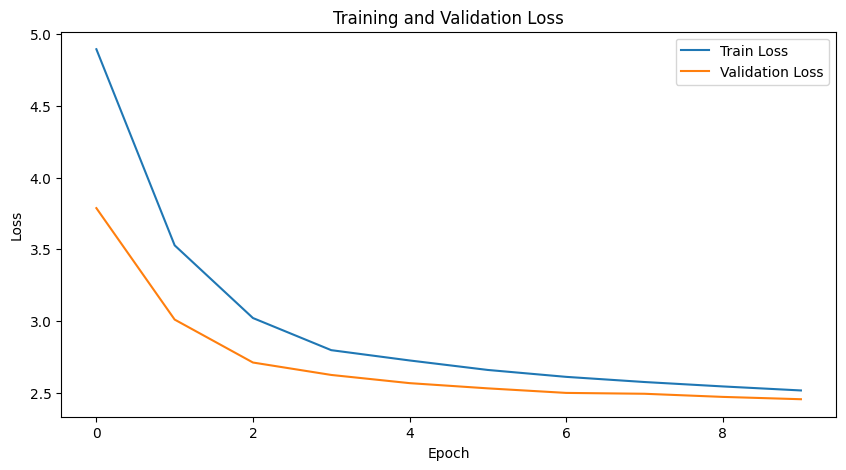

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
model.load_state_dict(torch.load('transformer-model-vlsp25.pt', map_location=DEVICE))
model.eval()
print("Model loaded")

Model loaded


In [26]:
import sacrebleu
import json

def calculate_sacrebleu_bleu(data, src_vocab, trg_vocab, model, device):
    trgs = []
    pred_trgs = []

    print(f"BLEU in {len(data)} test rows")

    for i, example in enumerate(data):
        src = example['src']
        trg = example['trg']

        pred_tokens = translate_sentence(src, src_vocab, trg_vocab, model, device)        
        pred_str = " ".join(pred_tokens)
        
        if isinstance(trg, str):
            trg_str = trg
        else:
            trg_str = " ".join(trg)

        pred_trgs.append(pred_str)
        trgs.append(trg_str)

        if i % 500 == 0:
            print(f"--- Sentence: {i} ---")
            print(f"Src : {src}")
            print(f"Trg : {trg_str}")
            print(f"Pred: {pred_str}")

    bleu = sacrebleu.corpus_bleu(pred_trgs, [trgs])

    with open("vlsp_transformer_predictions.json", 'w', encoding='utf-8') as f:
        json.dump(pred_trgs, f, ensure_ascii=False, indent=4)
    
    print(f"SacreBLEU score: {bleu.score}")
    
    return bleu.score

In [27]:
bleu_score = calculate_sacrebleu_bleu(test_data, src_vocab, trg_vocab, model, DEVICE)

BLEU in 3000 test rows
--- Sentence: 0 ---
Src : thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh viêng chăn, chdcnd lào, năm 2017
Trg : knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in vientiane, lao
Pred: knowledge and practice of people with health insurance services in public health facilities and some factors affecting in the province of <unk> , <unk> <unk> , 2017
--- Sentence: 500 ---
Src : kết quả cho thấy điểm chất lượng cuộc sống chung của người bệnh đái tháo đường là 62,10 ± 7,31, tương đương với chất lượng cuộc sống của người bệnh ở mức trung bình khá.
Trg : the results show that the overall quality of life score of diabetic patients is 62.10 ± 7.31, equivalent to the average quality of life of patients with diabetes.
Pred: the results showed that the general quality of life score of diabetes 

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


SacreBLEU score: 23.063180950489333
